In [7]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Use a stable GUI backend
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

In [3]:

# Load the dataset
df = pd.read_csv("NetworkIntrusion.csv")

# Print data types and check for nulls
print(df.dtypes)
print(df.isnull().sum())

# Check for placeholder anomalies
df_lower = df.apply(lambda x: x.astype(str).str.lower())
placeholders = ['unknown', '-999', 'n/a', 'none']
placeholder_found = False


for value in placeholders:
    total = (df_lower == value).sum().sum()
    if total > 0:
        print(f"Found {total} entries with placeholder: {value}")
        placeholder_found = True

# Summary print
if df.isnull().sum().sum() == 0 and not placeholder_found:
    print("✅ Summary: The dataset has no missing values and no placeholder anomalies ('unknown', '-999', 'n/a', 'none').")
else:
    print("⚠️ Summary: The dataset contains missing values or placeholder anomalies. Please review the detailed output above.")


duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

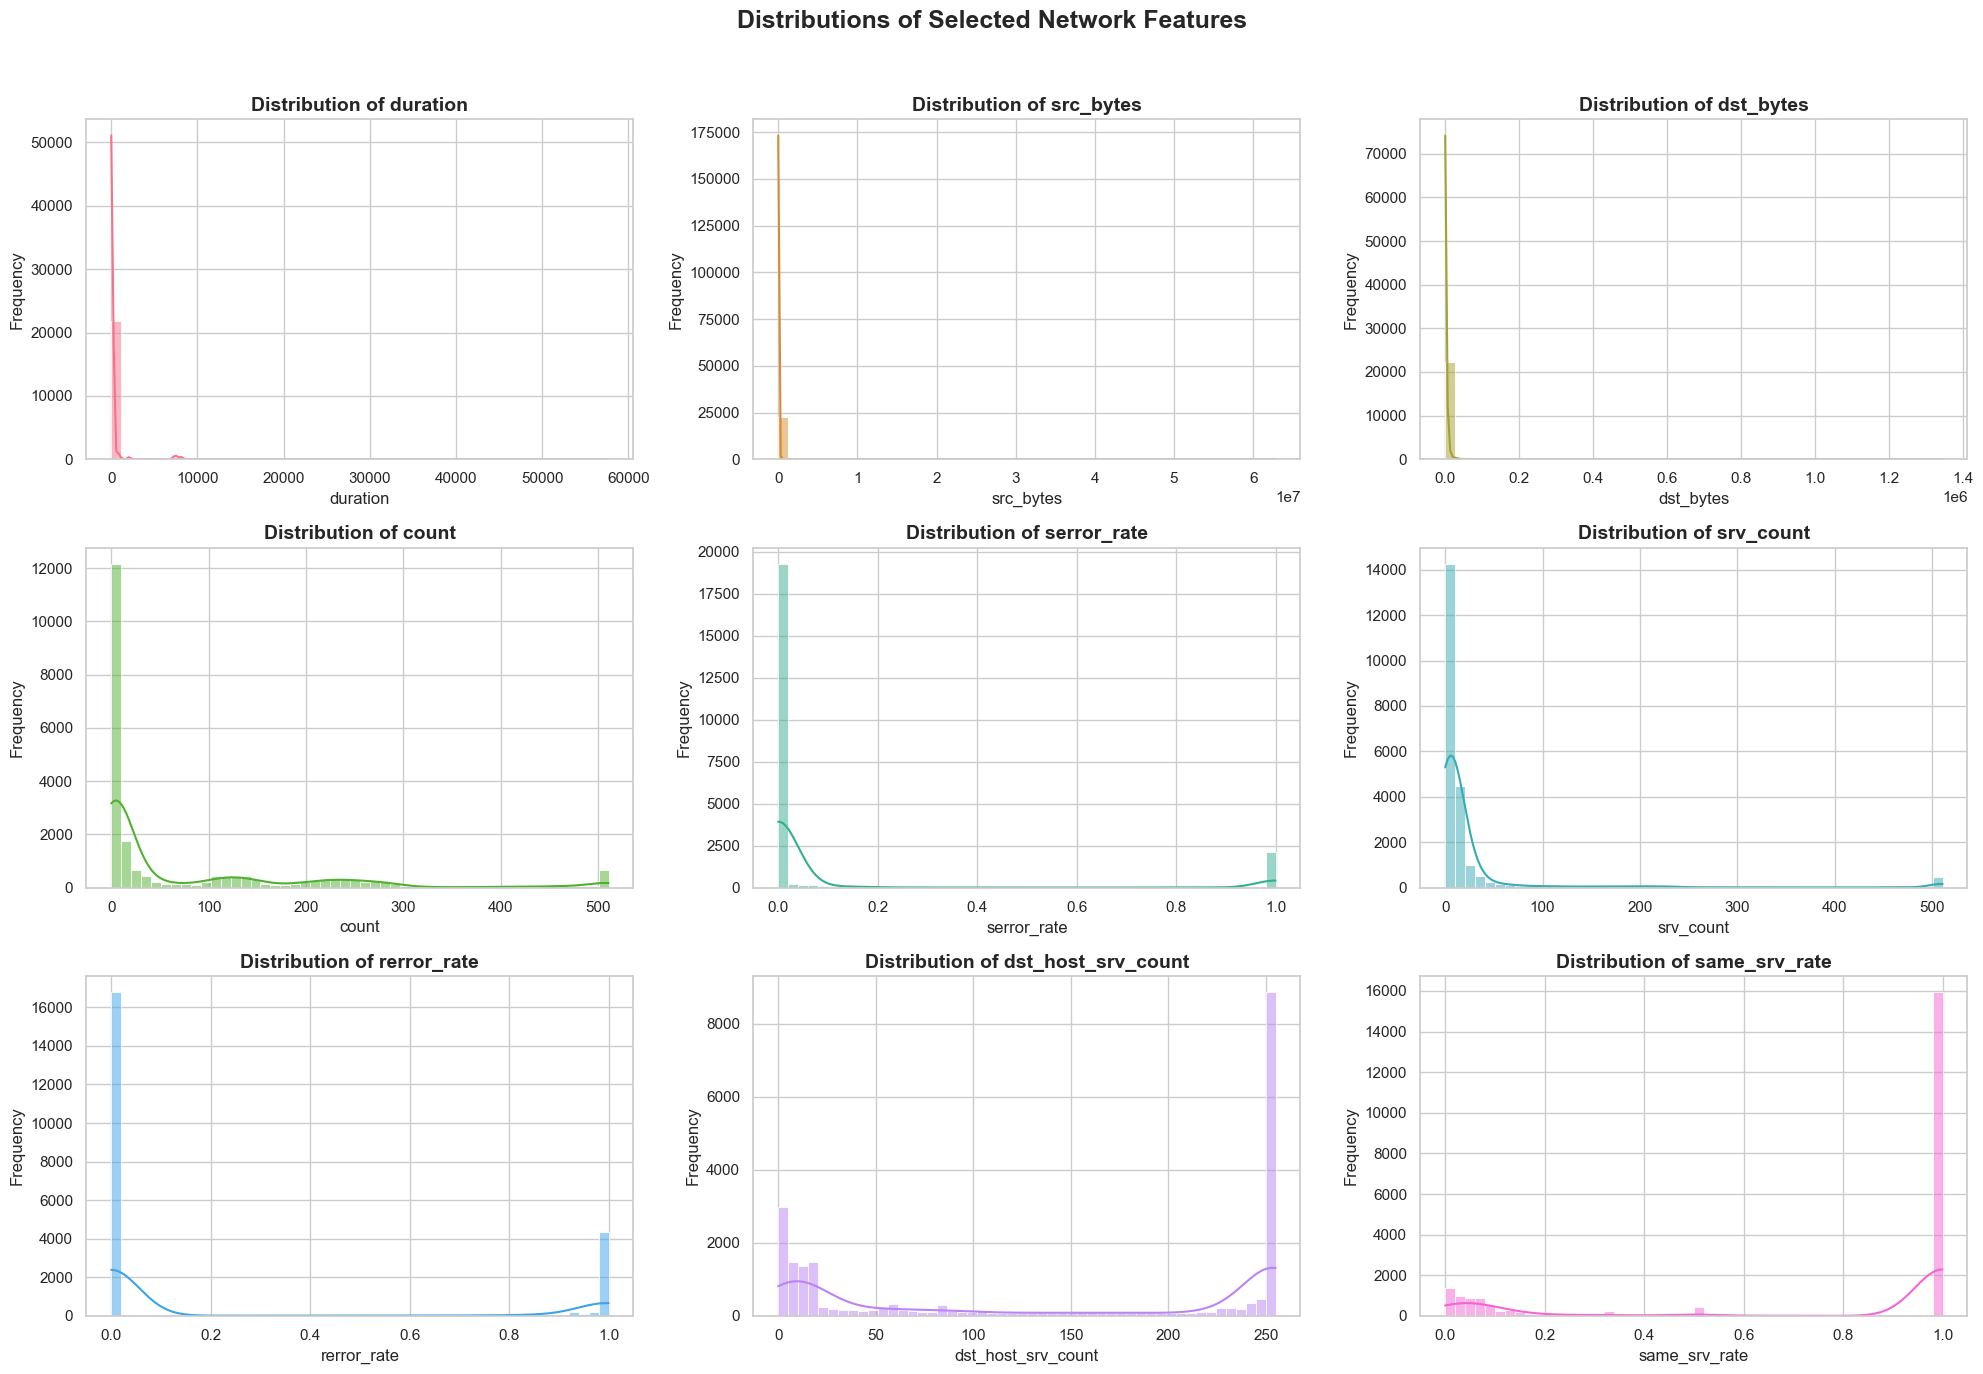

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Select numeric columns to visualize their distributions
selected_columns = [
    'duration',
    'src_bytes',
    'dst_bytes',
    'count',
    'serror_rate',
    'srv_count',
    'rerror_rate',
    'dst_host_srv_count',
    'same_srv_rate'
]


# Set the visual style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()
colors = sns.color_palette("husl", len(selected_columns))  # Colorful palette

# Plot histograms
for i, col in enumerate(selected_columns):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Hide any unused subplots (if less than 9)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Improve spacing
plt.suptitle("Distributions of Selected Network Features", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for main title
plt.show()

# Calculate statistics
central_stats = df[selected_columns].describe().T
central_stats['skew'] = df[selected_columns].skew()
central_stats['kurtosis'] = df[selected_columns].kurt()
central_stats_rounded = central_stats.round(3)


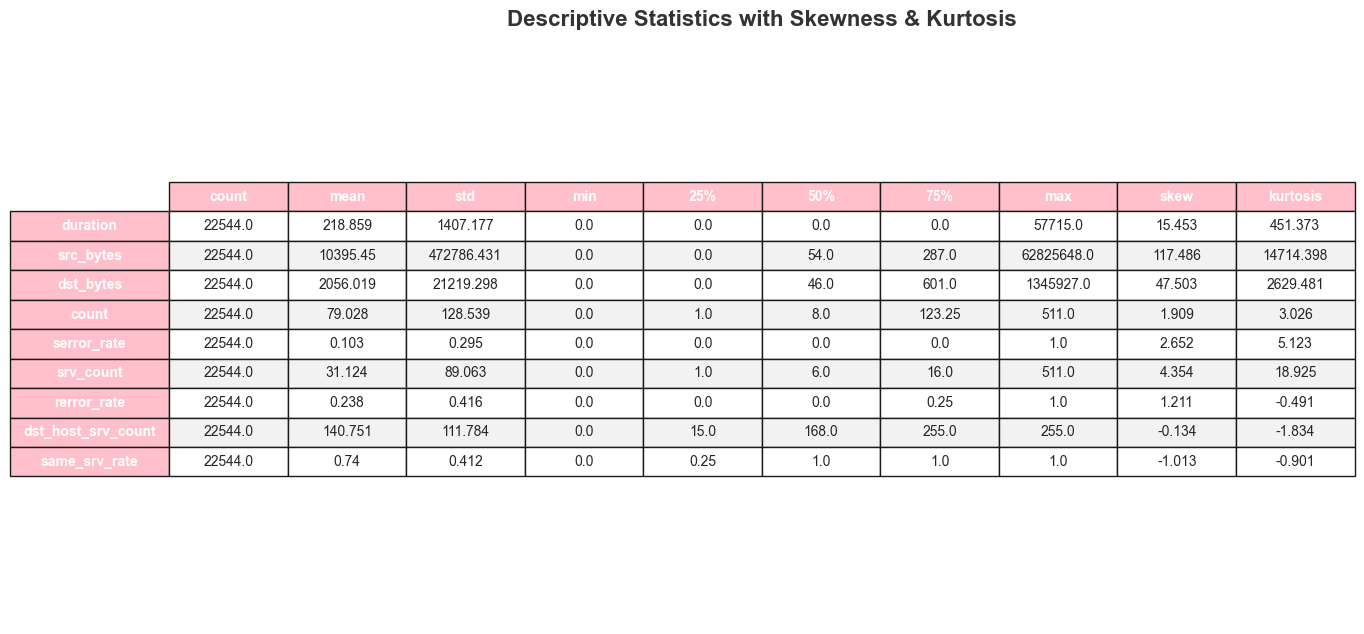

In [10]:
# Function to draw a styled table
def plot_styled_table(data, title):
    fig, ax = plt.subplots(figsize=(14, len(data) * 0.5 + 2))
    ax.axis('off')

    # Create the table
    table = ax.table(
        cellText=data.values,
        colLabels=data.columns,
        rowLabels=data.index,
        loc='center',
        cellLoc='center',
        rowLoc='center'
    )

    # Styling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Style header
    for key, cell in table.get_celld().items():
        row, col = key
        if row == 0 or col == -1:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#FFC0CB')  # Header background color
        elif row % 2 == 0:
            cell.set_facecolor('#F2F2F2')  # Even rows
        else:
            cell.set_facecolor('white')    # Odd rows

    # Title
    plt.title(title, fontsize=16, fontweight='bold', color='#333')
    plt.tight_layout()
    plt.show()

# Show the styled table
plot_styled_table(central_stats_rounded, "Descriptive Statistics with Skewness & Kurtosis")


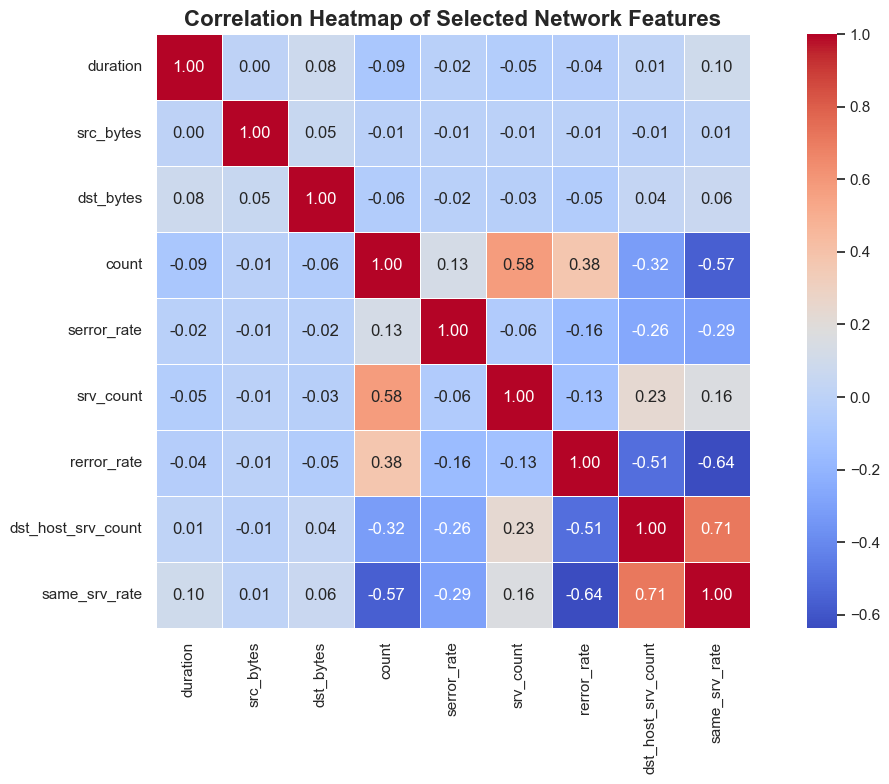

In [11]:

correlation_matrix = df[selected_columns].corr()


plt.figure(figsize=(12, 8))


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)


plt.title("Correlation Heatmap of Selected Network Features", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


📌 Number of duplicated rows: 57

📊 Number of unique values per column:
dst_bytes                      3650
src_bytes                      1149
duration                        624
count                           495
srv_count                       457
dst_host_srv_count              256
dst_host_count                  256
dst_host_rerror_rate            101
dst_host_srv_serror_rate        101
dst_host_same_src_port_rate     101
dst_host_diff_srv_rate          101
dst_host_same_srv_rate          101
dst_host_srv_rerror_rate        100
dst_host_serror_rate             99
diff_srv_rate                    99
srv_rerror_rate                  93
rerror_rate                      90
serror_rate                      88
srv_diff_host_rate               84
srv_serror_rate                  82
same_srv_rate                    75
service                          64
dst_host_srv_diff_host_rate      58
num_compromised                  23
num_root                         20
hot                          

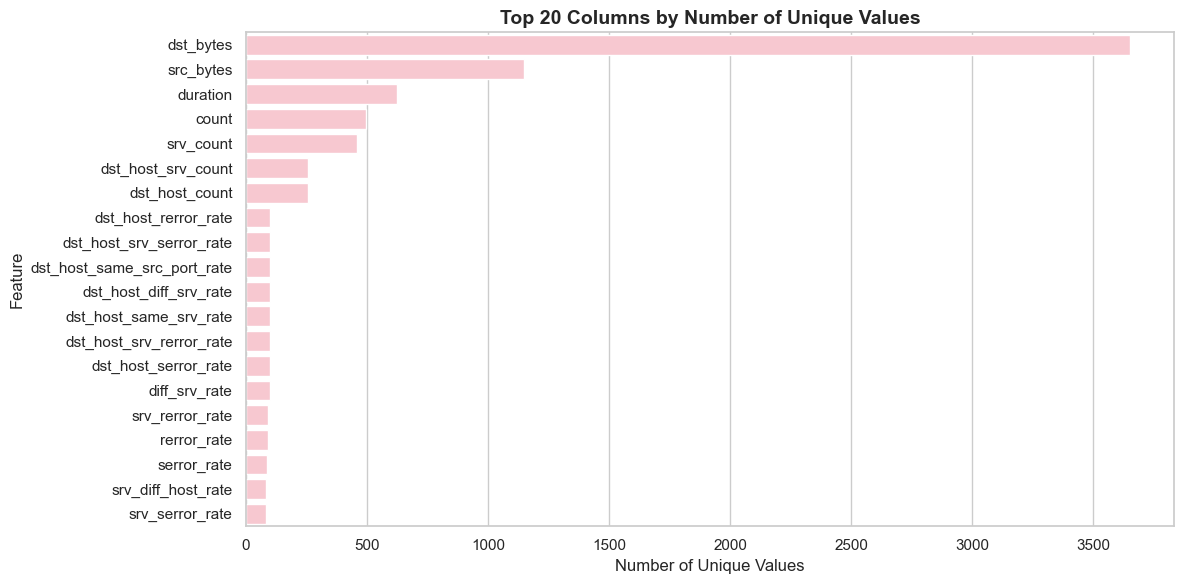

In [12]:

duplicate_rows = df.duplicated().sum()
print(f"📌 Number of duplicated rows: {duplicate_rows}")


unique_counts = df.nunique()
print("\n📊 Number of unique values per column:")
print(unique_counts.sort_values(ascending=False))


unique_cols = unique_counts[unique_counts == df.shape[0]]
print("\n✅ Columns with only unique values (e.g., IDs):")
print(unique_cols)

low_unique_cols = unique_counts[unique_counts <= 10]
print("\n🔍 Columns with low number of unique values (<=10):")
print(low_unique_cols)

top_unique_counts = df.nunique().sort_values(ascending=False).head(20)
pink_palette = ['#FFC0CB'] * len(top_unique_counts)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_unique_counts.values,
    y=top_unique_counts.index,
    hue=top_unique_counts.index,
    dodge=False,
    palette=pink_palette,
    legend=False
)

plt.title("Top 20 Columns by Number of Unique Values", fontsize=14, weight='bold')
plt.xlabel("Number of Unique Values")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



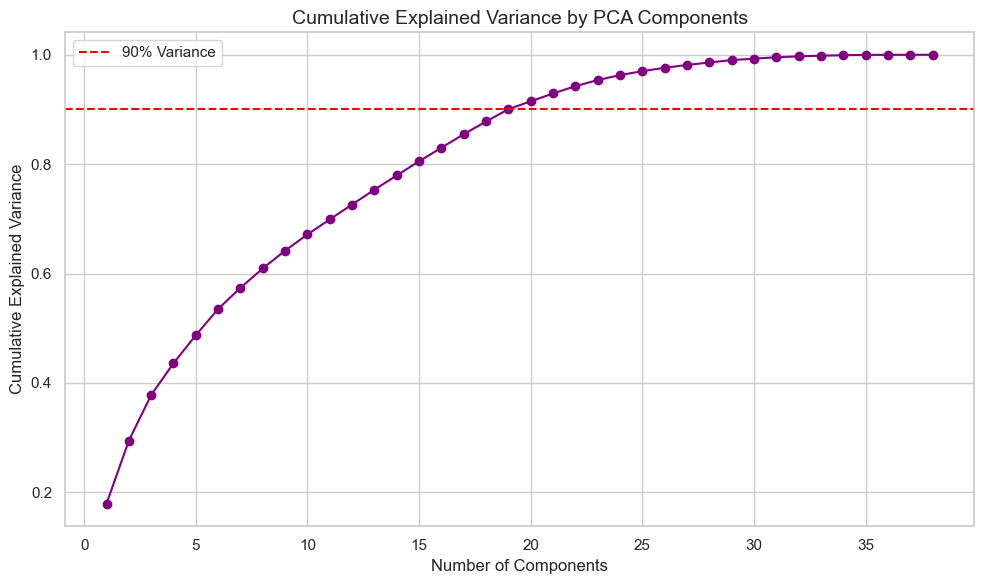

In [13]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include='number'))

pca_all = PCA()
pca_all.fit(scaled_data)

cumulative_variance = pca_all.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='purple')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


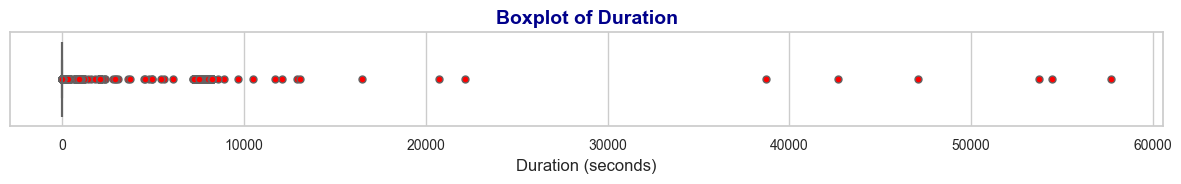

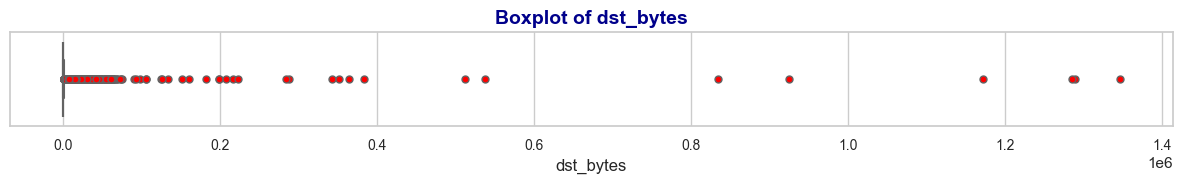

In [15]:

sns.set(style="whitegrid")

# Boxplot
plt.figure(figsize=(12, 2))
sns.boxplot(
    x=df['duration'],
    color='#9370DB',
    linewidth=1.5,
    fliersize=4,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
)


plt.title('Boxplot of Duration', fontsize=14, fontweight='bold', color='darkblue')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks([])


plt.tight_layout()
plt.show()




sns.set(style="whitegrid")


plt.figure(figsize=(12, 2))
sns.boxplot(
    x=df['dst_bytes'],
    color='#9370DB',
    linewidth=1.5,
    fliersize=4,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
)


plt.title('Boxplot of dst_bytes', fontsize=14, fontweight='bold', color='darkblue')
plt.xlabel('dst_bytes', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks([])

plt.tight_layout()
plt.show()



In [16]:

numerical_cols = df.select_dtypes(include='number').columns


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])


iso = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso.fit_predict(X_scaled)


df['Multivariate_Outlier'] = outlier_preds


print("Number of multivariate outliers:", sum(outlier_preds == -1))


Number of multivariate outliers: 1128


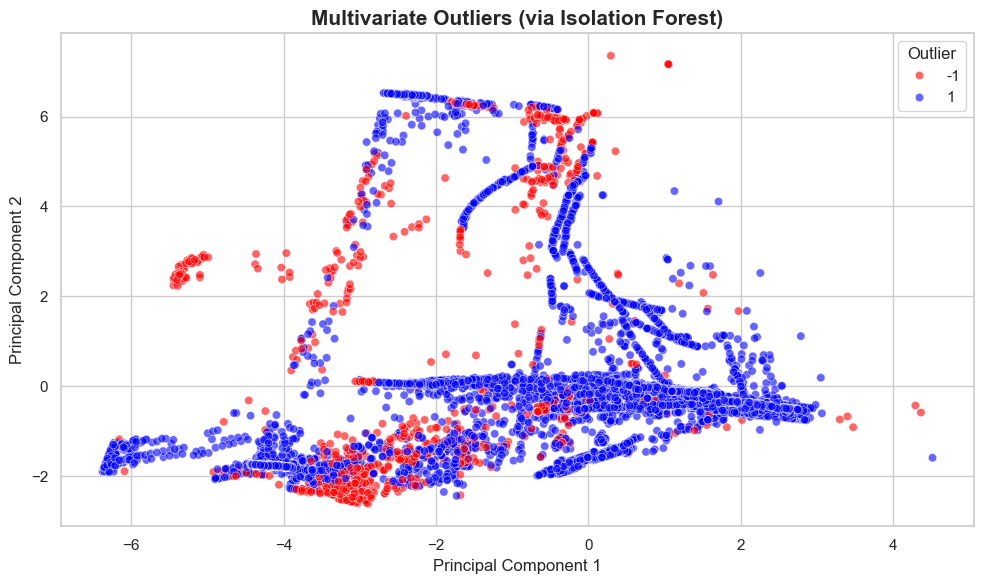

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Outlier'] = df['Multivariate_Outlier']


plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Outlier', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title('Multivariate Outliers (via Isolation Forest)', fontsize=15, weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()



Number of Z-Score outliers: 7429


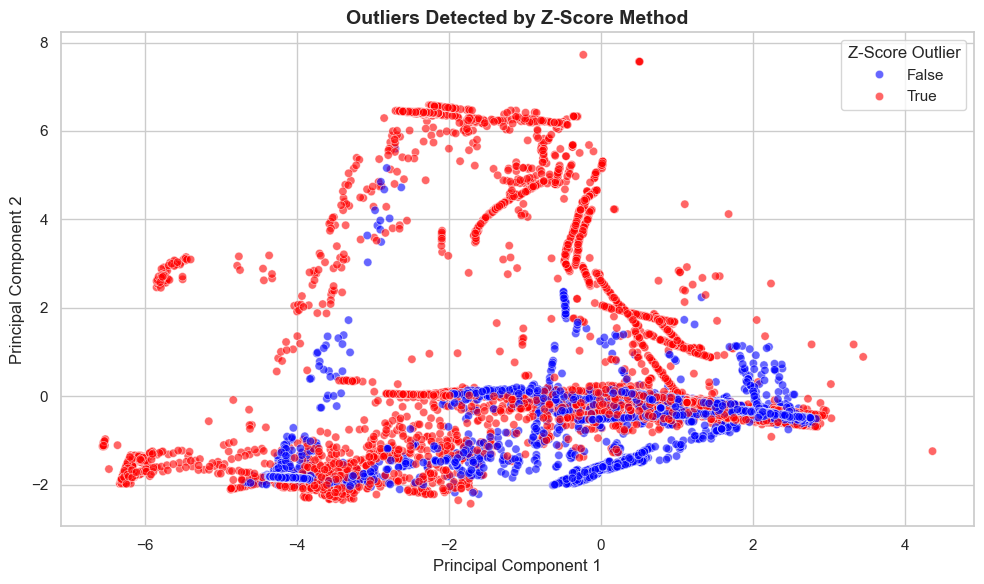

In [18]:
from scipy import stats
import numpy as np

# Select numerical columns
numeric_cols = df.select_dtypes(include='number').columns

# Compute Z-scores
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Define threshold for outliers
z_threshold = 3

# Boolean mask for outliers (any column > threshold)
z_outliers = (z_scores > z_threshold).any(axis=1)

# Add column to DataFrame indicating Z-score outliers
df['ZScore_Outlier'] = z_outliers

# Count and print number of outliers
print(f"Number of Z-Score outliers: {df['ZScore_Outlier'].sum()}")

# Plot Z-score outliers on PCA 2D projection
pca_z = PCA(n_components=2)
pca_z_result = pca_z.fit_transform(StandardScaler().fit_transform(df[numeric_cols]))

pca_z_df = pd.DataFrame(pca_z_result, columns=['PC1', 'PC2'])
pca_z_df['ZScore_Outlier'] = df['ZScore_Outlier']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_z_df, x='PC1', y='PC2',
                hue='ZScore_Outlier', palette={False: 'blue', True: 'red'}, alpha=0.6)
plt.title('Outliers Detected by Z-Score Method', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Z-Score Outlier')
plt.tight_layout()
plt.show()

Number of IQR outliers: 5855


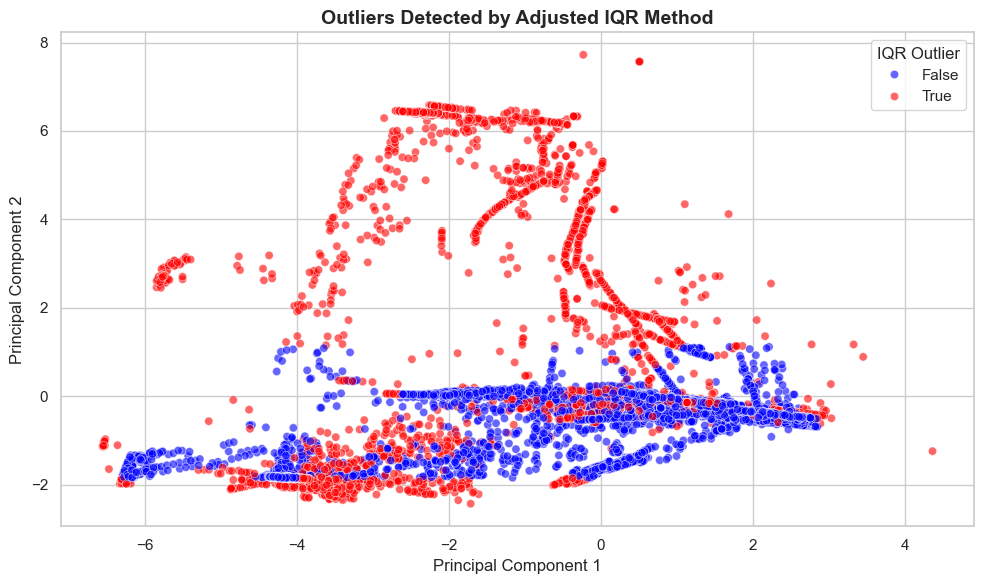

In [21]:
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaled_data)


Q1 = np.percentile(pca_data, 25, axis=0)
Q3 = np.percentile(pca_data, 75, axis=0)
IQR = Q3 - Q1


lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR


iqr_outliers = ((pca_data < lower_bound) | (pca_data > upper_bound)).any(axis=1)

df['IQR_Outlier'] = iqr_outliers
print(f"Number of IQR outliers: {df['IQR_Outlier'].sum()}")


pca_2d = PCA(n_components=2)
pca_2d_data = pca_2d.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_2d_data, columns=['PC1', 'PC2'])
pca_df['IQR_Outlier'] = df['IQR_Outlier']


plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='IQR_Outlier', palette={False: 'blue', True: 'red'}, alpha=0.6)
plt.title('Outliers Detected by Adjusted IQR Method', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='IQR Outlier')
plt.tight_layout()
plt.show()


Number of Mahalanobis outliers: 1475


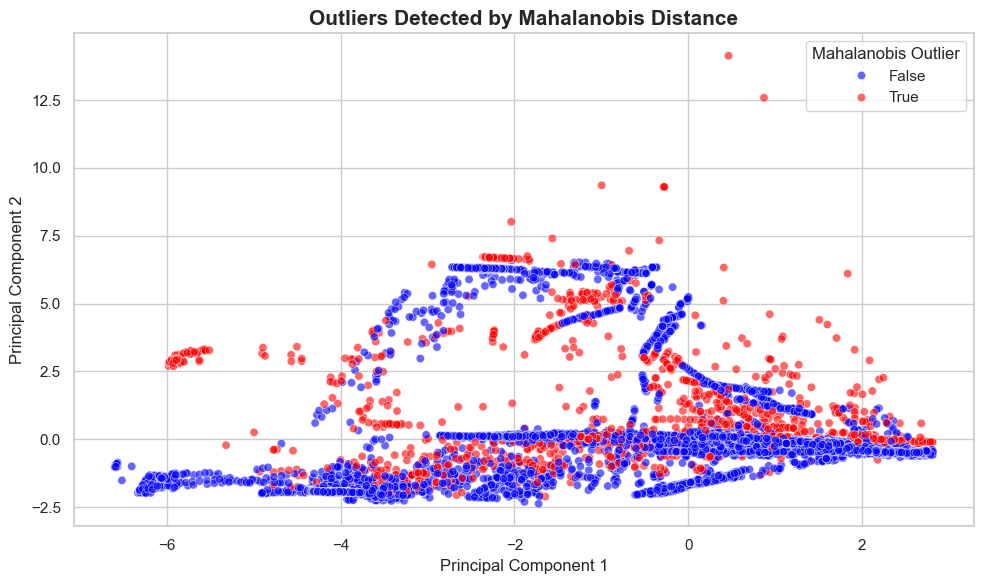

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Mahalanobis Distance Outlier Detection ---
data_numeric = df.select_dtypes(include='number')

# Standardize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Mean and covariance
mean_vec = np.mean(data_scaled, axis=0)
cov_matrix = np.cov(data_scaled, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse to avoid singular matrix

# Compute Mahalanobis distances
mahal_dist = [np.sqrt((x - mean_vec) @ inv_cov_matrix @ (x - mean_vec).T) for x in data_scaled]
df['Mahalanobis_Distance'] = mahal_dist

# Determine threshold using Chi-square distribution (p=0.001)
threshold = np.sqrt(chi2.ppf(0.999, df=data_scaled.shape[1]))

# Outlier mask
outliers = np.array(mahal_dist) > threshold
df['Mahalanobis_Outlier'] = outliers

print(f"Number of Mahalanobis outliers: {df['Mahalanobis_Outlier'].sum()}")

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Mahalanobis_Outlier'] = outliers

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='Mahalanobis_Outlier', palette={False: 'blue', True: 'red'}, alpha=0.6)
plt.title('Outliers Detected by Mahalanobis Distance', fontsize=15, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Mahalanobis Outlier')
plt.tight_layout()
plt.show()



--- Chebyshev Inequality Outlier Detection ---
Number of Chebyshev outliers: 7433


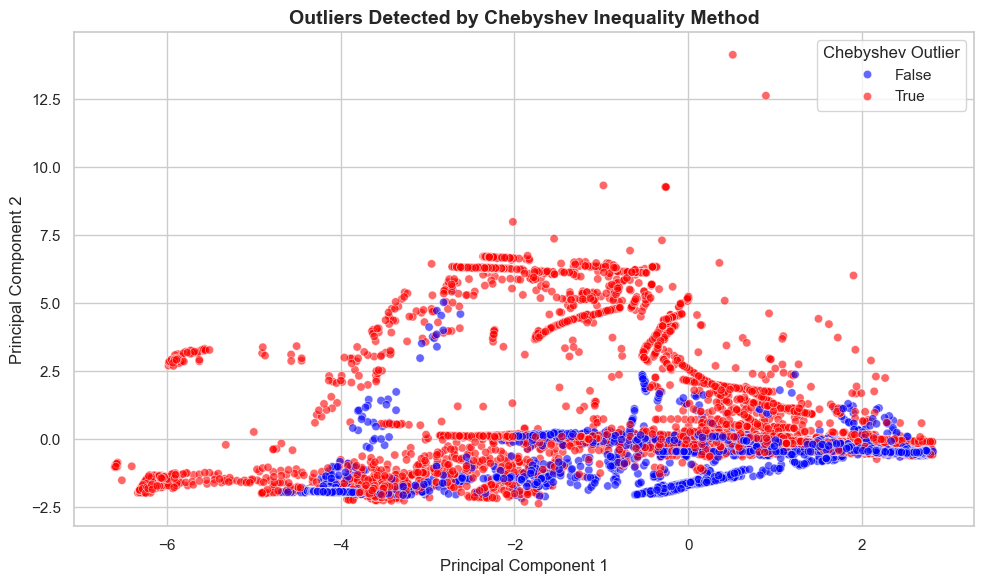

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- Chebyshev Inequality Outlier Detection ---
print("\n--- Chebyshev Inequality Outlier Detection ---")

# نختار الأعمدة الرقمية
numeric_cols = df.select_dtypes(include='number').columns
data_numeric = df[numeric_cols]

# نعمل Standardization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# نحدد قيمة k (عدد الانحرافات المعيارية)
k = 3  # ممكن تغيرها مثلاً 2.5 إذا بدك حساسية أكبر

# نحسب المتوسط والانحراف المعياري
mean_vals = np.mean(data_scaled, axis=0)
std_vals = np.std(data_scaled, axis=0)

# Boolean mask للكشف عن القيم الشاذة
chebyshev_mask = (np.abs(data_scaled - mean_vals) > k * std_vals).any(axis=1)

# نضيفها للـ DataFrame
df['Chebyshev_Outlier'] = chebyshev_mask

# نطبع عدد القيم الشاذة
print(f"Number of Chebyshev outliers: {df['Chebyshev_Outlier'].sum()}")

# --- Visualization using PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Chebyshev_Outlier'] = df['Chebyshev_Outlier']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='Chebyshev_Outlier',
    palette={False: 'blue', True: 'red'},
    alpha=0.6
)
plt.title('Outliers Detected by Chebyshev Inequality Method', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Chebyshev Outlier')
plt.tight_layout()
plt.show()


Number of One-Class SVM outliers: 1109


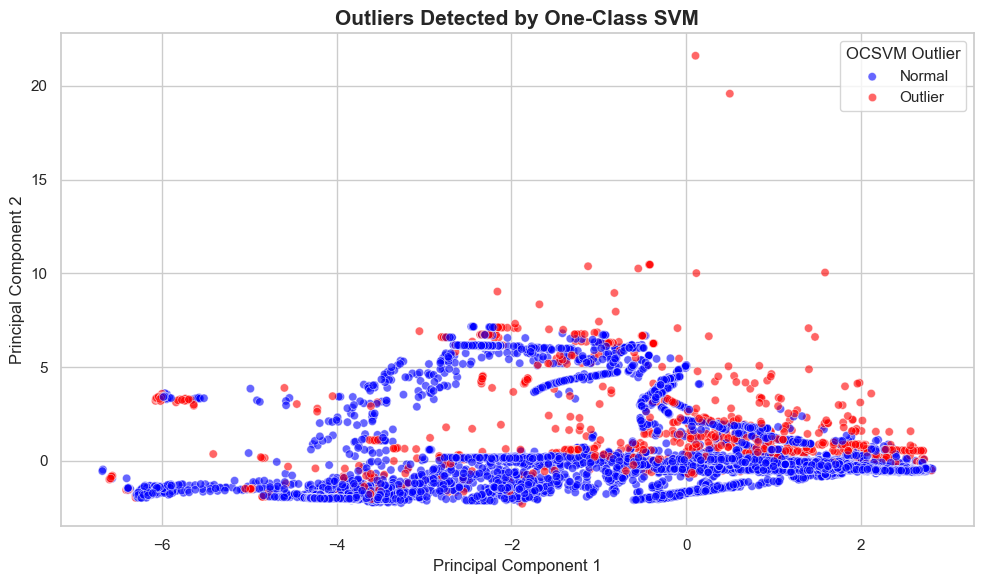

In [27]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


numeric_df = df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  
ocsvm.fit(scaled_data)

ocsvm_preds = ocsvm.predict(scaled_data)
df['OCSVM_Outlier'] = ocsvm_preds

num_outliers = (ocsvm_preds == -1).sum()
print(f"Number of One-Class SVM outliers: {num_outliers}")


pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['OCSVM_Outlier'] = df['OCSVM_Outlier']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='OCSVM_Outlier',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title('Outliers Detected by One-Class SVM', fontsize=15, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='OCSVM Outlier', labels=['Normal', 'Outlier'])
plt.tight_layout()
plt.show()



--- Local Outlier Factor (LOF) Outlier Detection ---
Number of LOF outliers: 1128


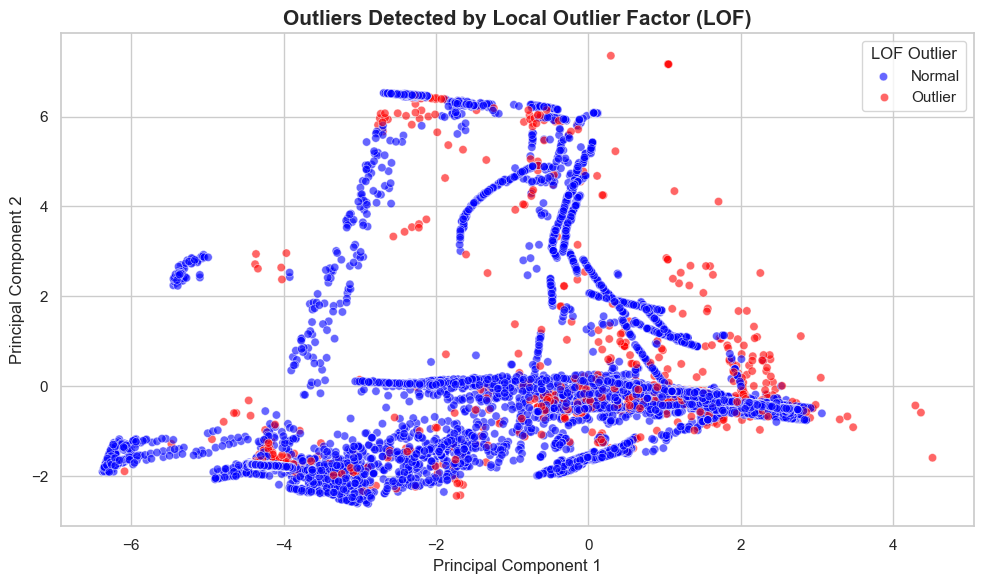

In [28]:
from sklearn.neighbors import LocalOutlierFactor

print("\n--- Local Outlier Factor (LOF) Outlier Detection ---")

# 1️⃣ إنشاء النموذج
lof = LocalOutlierFactor(
    n_neighbors=20,  # عدد الجيران
    contamination=0.05  # نسبة التلوث المتوقعة
)

# 2️⃣ التنبؤ بالقيم الشاذة
lof_preds = lof.fit_predict(X_scaled)  # X_scaled هو البيانات المعيارية
# -1 = Outlier, 1 = Normal
df['LOF_Outlier'] = lof_preds

# 3️⃣ عدّ القيم الشاذة
n_outliers_lof = (lof_preds == -1).sum()
print(f"Number of LOF outliers: {n_outliers_lof}")

# 4️⃣ تجهيز بيانات PCA للرسم
pca_lof = PCA(n_components=2)
pca_lof_result = pca_lof.fit_transform(X_scaled)

pca_lof_df = pd.DataFrame(pca_lof_result, columns=['PC1', 'PC2'])
pca_lof_df['LOF_Outlier'] = df['LOF_Outlier']

# 5️⃣ رسم القيم الشاذة
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_lof_df,
    x='PC1', y='PC2',
    hue='LOF_Outlier',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title('Outliers Detected by Local Outlier Factor (LOF)', fontsize=15, weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='LOF Outlier', labels=['Normal', 'Outlier'])
plt.tight_layout()
plt.show()


Number of PCA Reconstruction Error outliers: 1128


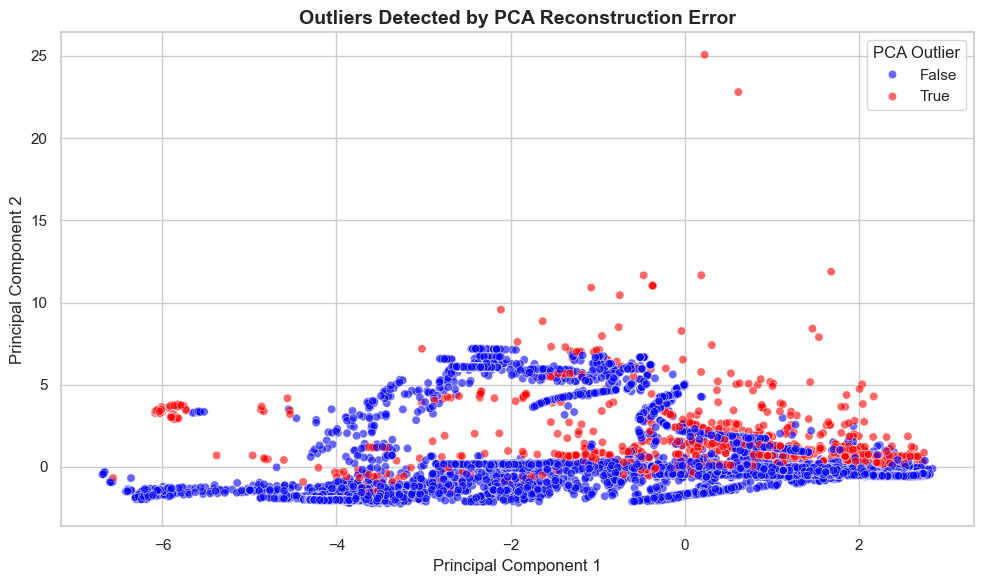

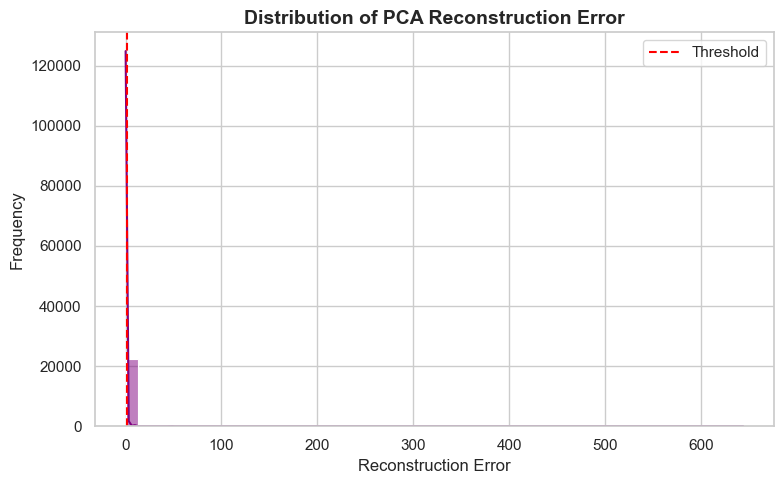

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# نأخذ فقط الأعمدة الرقمية
numeric_df = df.select_dtypes(include='number')

# نعمل Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# نعمل PCA بعدد مكونات قليل (مثلاً 5)
pca = PCA(n_components=5, random_state=42)
pca_data = pca.fit_transform(scaled_data)

# نعيد بناء البيانات من المكونات
reconstructed_data = pca.inverse_transform(pca_data)

# نحسب خطأ إعادة البناء (MSE لكل صف)
reconstruction_error = np.mean((scaled_data - reconstructed_data) ** 2, axis=1)

# نضيف الخطأ للـ DataFrame
df['PCA_Reconstruction_Error'] = reconstruction_error

# نحدد العتبة (مثلاً 95th percentile)
threshold = np.percentile(reconstruction_error, 95)

# نحدد القيم الشاذة
df['PCA_Outlier'] = df['PCA_Reconstruction_Error'] > threshold

# عدد القيم الشاذة
num_outliers = df['PCA_Outlier'].sum()
print(f"Number of PCA Reconstruction Error outliers: {num_outliers}")

# نعمل PCA لـ 2 مكون للعرض
pca_2d = PCA(n_components=2, random_state=42)
pca_2d_data = pca_2d.fit_transform(scaled_data)
pca_2d_df = pd.DataFrame(pca_2d_data, columns=['PC1', 'PC2'])
pca_2d_df['PCA_Outlier'] = df['PCA_Outlier']

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_2d_df, x='PC1', y='PC2',
                hue='PCA_Outlier', palette={False: 'blue', True: 'red'}, alpha=0.6)
plt.title('Outliers Detected by PCA Reconstruction Error', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='PCA Outlier')
plt.tight_layout()
plt.show()

# Histogram للأخطاء
plt.figure(figsize=(8, 5))
sns.histplot(reconstruction_error, bins=50, kde=True, color='purple')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of PCA Reconstruction Error', fontsize=14, fontweight='bold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


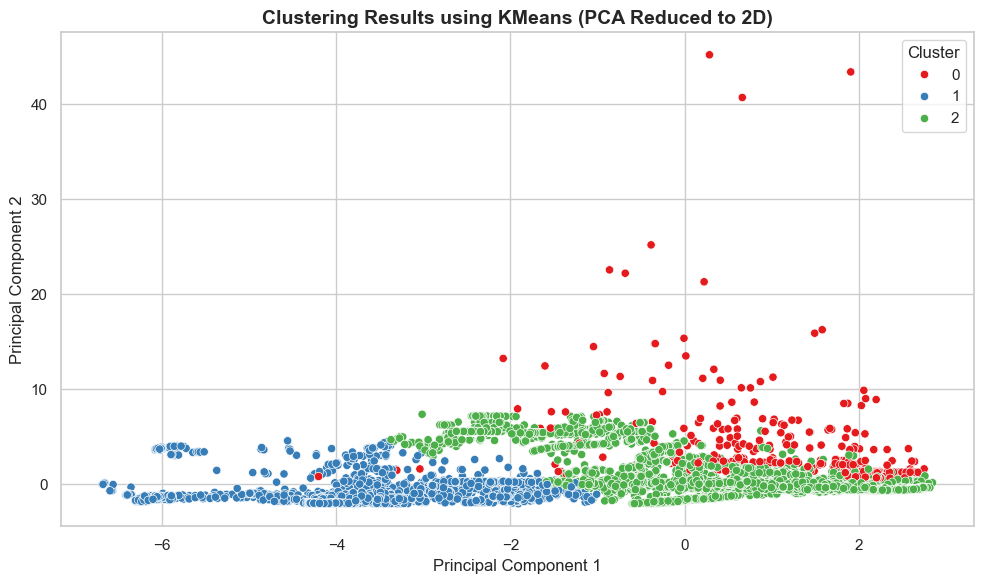

In [35]:
df_with_labels = df.copy()
df_with_labels['Cluster'] = labels

# 7. Create DataFrame with first 2 PCA components for plotting
pca_df = pd.DataFrame(pca_data[:, :2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels

# 8. Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title('Clustering Results using KMeans (PCA Reduced to 2D)', fontsize=14, weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:

# 9. Summary statistics for numerical columns per cluster
numeric_cols = df_with_labels.select_dtypes(include='number').columns
cluster_summary = df_with_labels[numeric_cols].groupby('Cluster').mean()
print("\nCluster Summary (mean of numerical features):")
print(cluster_summary)

# 10. Distribution of protocol types within each cluster (if column exists)
if 'protocol_type' in df_with_labels.columns:
    for i in range(3):
        print(f"\nProtocol type distribution in Cluster {i}:")
        print(df_with_labels[df_with_labels['Cluster'] == i]['protocol_type'].value_counts())



Cluster Summary (mean of numerical features):
           duration      src_bytes    dst_bytes      land  wrong_fragment  \
Cluster                                                                     
0        932.093240  238315.620047  28622.18648  0.016317         0.44289   
1         16.169038      22.243167     20.27368  0.000000         0.00000   
2        265.171168    7869.719549   2024.90121  0.000000         0.00000   

           urgent       hot  num_failed_logins  logged_in  num_compromised  \
Cluster                                                                      
0        0.037296  1.128205           0.039627   0.391608         5.494172   
1        0.000000  0.001872           0.002434   0.026582         0.000000   
2        0.000000  0.112204           0.027306   0.575866         0.020628   

         ...  dst_host_srv_diff_host_rate  dst_host_serror_rate  \
Cluster  ...                                                      
0        ...                     0.359930 

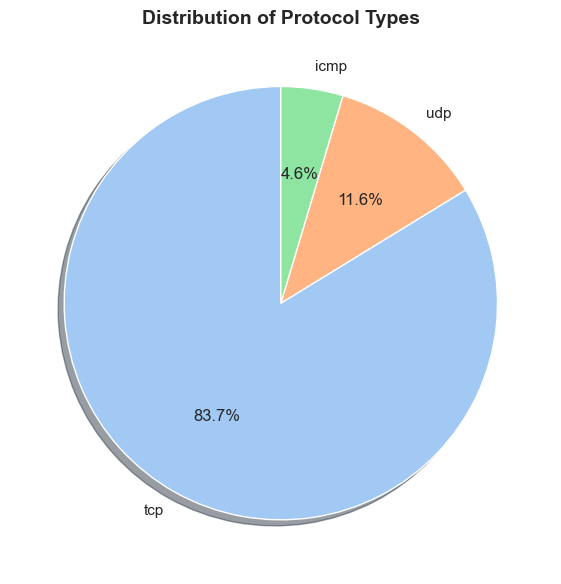

In [38]:
# Pie chart of protocol_type distribution
protocol_counts = df['protocol_type'].value_counts()

plt.figure(figsize=(6, 6))
protocol_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    colors=sns.color_palette("pastel")
)
plt.title("Distribution of Protocol Types", fontsize=14, weight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

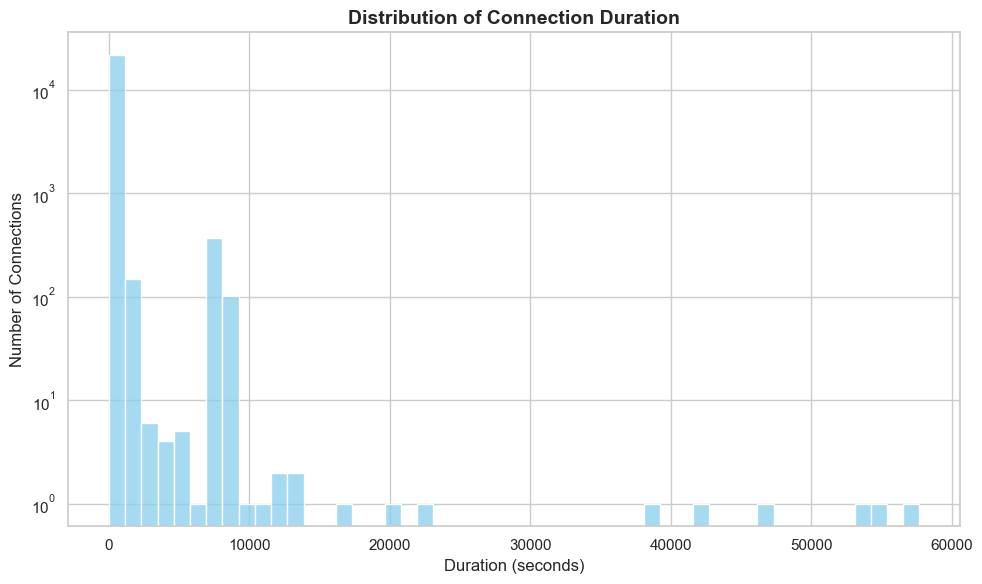

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Connection Duration', fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Connections')
plt.yscale('log')
plt.tight_layout()
plt.show()


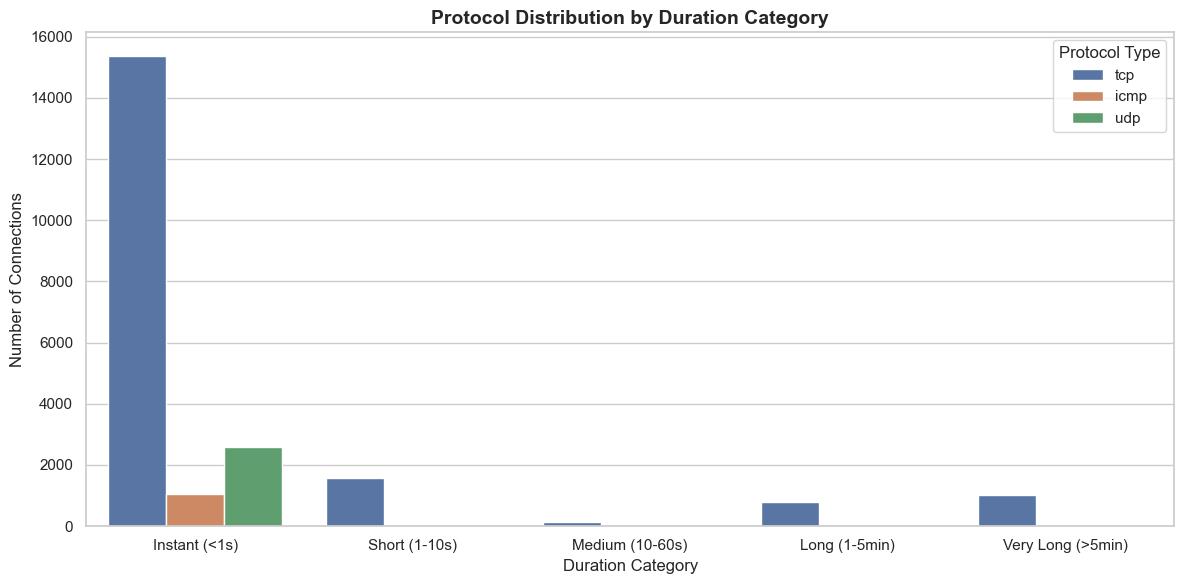

In [40]:

def categorize_duration(sec):
    if sec == 0:
        return 'Instant (<1s)'
    elif sec <= 10:
        return 'Short (1-10s)'
    elif sec <= 60:
        return 'Medium (10-60s)'
    elif sec <= 300:
        return 'Long (1-5min)'
    else:
        return 'Very Long (>5min)'

df['duration_category'] = df['duration'].apply(categorize_duration)


plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='duration_category', hue='protocol_type',
              order=['Instant (<1s)', 'Short (1-10s)', 'Medium (10-60s)', 'Long (1-5min)', 'Very Long (>5min)'])
plt.title('Protocol Distribution by Duration Category', fontsize=14, fontweight='bold')
plt.xlabel('Duration Category')
plt.ylabel('Number of Connections')
plt.legend(title='Protocol Type')
plt.tight_layout()
plt.show()

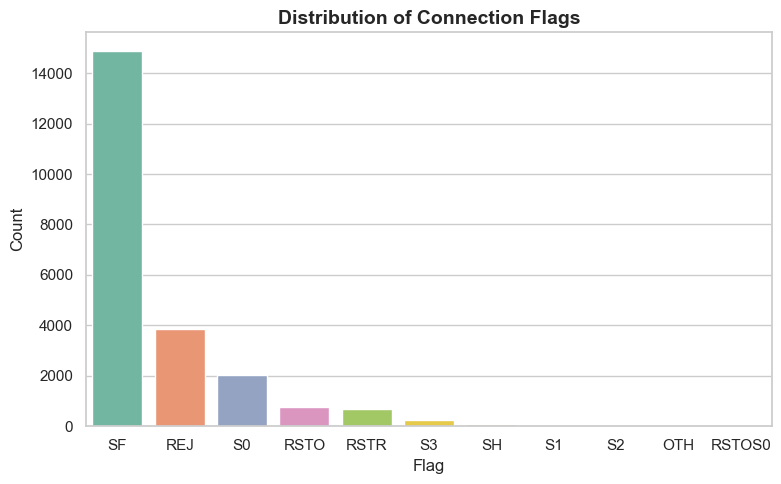

In [42]:
# Bar plot for flag distribution
flag_counts = df['flag'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=flag_counts.index, y=flag_counts.values, hue=flag_counts.index, dodge=False, palette="Set2", legend=False)
plt.title("Distribution of Connection Flags", fontsize=14, weight='bold')
plt.xlabel("Flag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

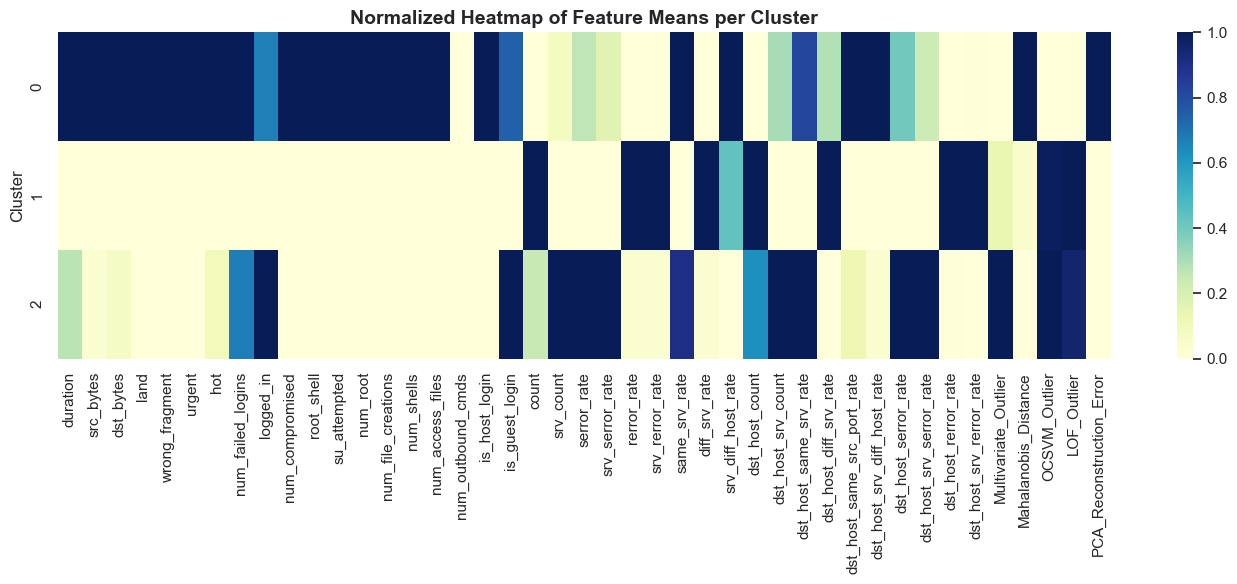

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the cluster summary values for heatmap clarity
scaler = MinMaxScaler()
normalized_summary = pd.DataFrame(scaler.fit_transform(cluster_summary),
                                  columns=cluster_summary.columns,
                                  index=cluster_summary.index)

# Re-plot heatmap with normalized values
plt.figure(figsize=(14, 6))
sns.heatmap(normalized_summary, annot=False, cmap="YlGnBu")
plt.title("Normalized Heatmap of Feature Means per Cluster", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

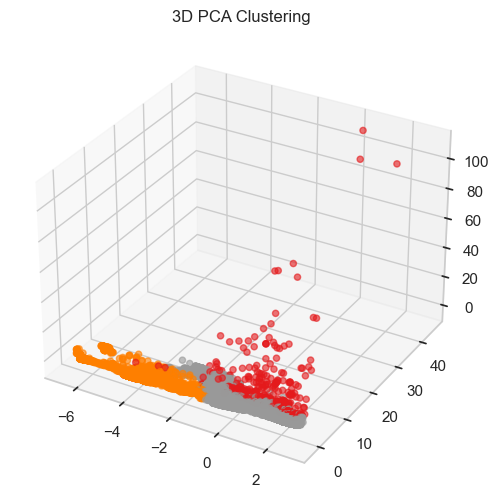

In [44]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3).fit_transform(scaled_data)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=labels, cmap='Set1', alpha=0.6)
ax.set_title("3D PCA Clustering")
plt.show()

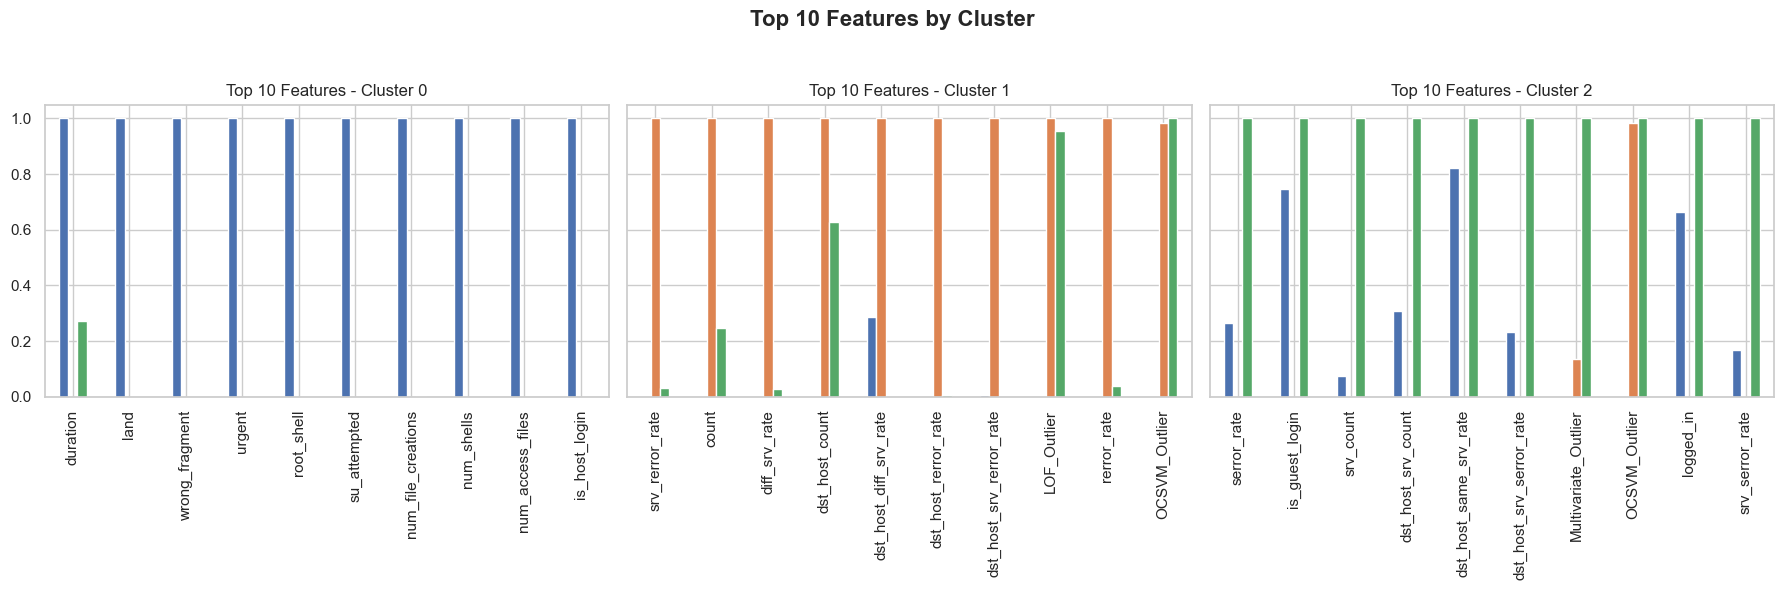

In [45]:
top_features_0 = normalized_summary.T.nlargest(10, 0)
top_features_1 = normalized_summary.T.nlargest(10, 1)
top_features_2 = normalized_summary.T.nlargest(10, 2)


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Cluster 0
top_features_0.plot(kind='bar', ax=axes[0], legend=False)
axes[0].set_title("Top 10 Features - Cluster 0")
axes[0].tick_params(axis='x', rotation=90)

# Cluster 1
top_features_1.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_title("Top 10 Features - Cluster 1")
axes[1].tick_params(axis='x', rotation=90)

# Cluster 2
top_features_2.plot(kind='bar', ax=axes[2], legend=False)
axes[2].set_title("Top 10 Features - Cluster 2")
axes[2].tick_params(axis='x', rotation=90)



fig.suptitle("Top 10 Features by Cluster", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



